In [1]:
import pickle
import lzma

with lzma.open('movie_data_movielens.xz', 'rb') as f:
    train_movie_ratings_list, test_movie_ratings_list = pickle.load(f)

with lzma.open('user_data_movielens.xz', 'rb') as f:
    train_user_ratings_list, test_user_ratings_list = pickle.load(f)

In [2]:
import numpy as np

def arraylize(input_list):
    return [np.array(val) for val in input_list]

train_movie_ratings_list = arraylize(train_movie_ratings_list)
test_movie_ratings_list = arraylize(test_movie_ratings_list)
train_user_ratings_list = arraylize(train_user_ratings_list)
test_user_ratings_list = arraylize(test_user_ratings_list)

In [3]:
with lzma.open('params_2024-05-02 11:05:36.932319.xz', 'rb') as f:
    params = pickle.load(f)

locals().update(params)

In [3]:
M = len(train_user_ratings_list)
N = len(train_movie_ratings_list)

user_biases = np.zeros((M))
item_biases = np.zeros((N))

# Hyperparameters
n_epochs = 100
lmb = 1
gamma = 0
tau = 1
k = 20

U = np.random.normal(loc=0.0, scale=1/np.sqrt(k), size=(M, k))
V = np.random.normal(loc=0.0, scale=1/np.sqrt(k), size=(N, k))

train_losses = []
train_rmses = []
test_losses = []
test_rmses = []

In [4]:
from tqdm.notebook import tqdm

for i in tqdm(range(n_epochs)):
    for m in range(M):
        # Extract ratings and indices for the current user
        if len(train_user_ratings_list) > 0:
            ratings = train_user_ratings_list[m][:, 1]
            indices = train_user_ratings_list[m][:, 0].astype(int)
            
            # Calculate user bias
            user_bias = lmb * np.sum(ratings - np.einsum('i,ji->j', U[m], V[indices]) - item_biases[indices]) / (lmb * len(indices) + gamma)
            user_biases[m] = user_bias
            
            # Calculate left and right matrices for user factor update
            left = np.sum(np.einsum('ij,il->ijl', V[indices], V[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', V[indices], ratings - user_bias - item_biases[indices]), axis=0)
            
            # Update user factor
            U[m] = np.linalg.solve(lmb * left + tau * np.eye(k), lmb * right)

    for n in range(N):
        # Extract ratings and indices for the current item
        if len(train_movie_ratings_list[n]) > 0:
            ratings = train_movie_ratings_list[n][:, 1]
            indices = train_movie_ratings_list[n][:, 0].astype(int)
            
            # Calculate item bias
            item_bias = lmb * np.sum(ratings - np.einsum('ij,j->i', U[indices], V[n]) - user_biases[indices]) / (lmb * len(indices) + gamma)
            item_biases[n] = item_bias
            
            # Calculate left and right matrices for item factor update
            left = np.sum(np.einsum('ij,il->ijl', U[indices], U[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', U[indices], ratings - user_biases[indices] - item_bias), axis=0)
            
            # Update item factor
            V[n] = np.linalg.solve(lmb * left + tau * np.eye(k), lmb * right)

    # Calculate loss and RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0
    
    for m in range(M):
        if len(train_user_ratings_list[m]) > 0:
            train_ratings = train_user_ratings_list[m][:, 1]
            train_indices = train_user_ratings_list[m][:, 0].astype(int)
            train_error_squared += np.sum((train_ratings - np.einsum('i,ji->j', U[m], V[train_indices]) - user_biases[m] - item_biases[train_indices])**2)
            train_size += len(train_indices)
            
        if len(test_user_ratings_list[m]) > 0:
            test_ratings = test_user_ratings_list[m][:, 1]
            test_indices = test_user_ratings_list[m][:, 0].astype(int)
            test_error_squared += np.sum((test_ratings - np.einsum('i,ji->j', U[m], V[test_indices]) - user_biases[m] - item_biases[test_indices])**2)
            test_size += len(test_indices)
        
    train_loss = -0.5 * lmb * train_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', V, V) + np.einsum('ij,ij->', U, U))
    train_rmse = np.sqrt(1 / train_size * train_error_squared)
    
    train_losses.append(-1*train_loss)
    train_rmses.append(train_rmse)

    test_loss = -0.5 * lmb * test_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij, ij->', V, V) + np.einsum('ij, ij->', U, U))
    test_rmse = np.sqrt(1/test_size * test_error_squared)
    
    test_losses.append(-1*test_loss)
    test_rmses.append(test_rmse)
        
    print(f'train loss {round(-1*train_loss, 2)} test loss {round(-1*test_loss, 2)} train rmse {round(train_rmse, 4)} test rmse {round(test_rmse, 4)}')

  0%|          | 0/100 [00:00<?, ?it/s]

train loss 6506173.1 test loss 2412518.58 train rmse 0.7903 test rmse 0.928
train loss 5532990.73 test loss 2200822.35 train rmse 0.7269 test rmse 0.8837
train loss 5045605.26 test loss 2064538.23 train rmse 0.6932 test rmse 0.8544
train loss 4801378.25 test loss 1992991.31 train rmse 0.676 test rmse 0.8393
train loss 4662305.32 test loss 1951915.36 train rmse 0.6661 test rmse 0.8311
train loss 4574630.57 test loss 1926047.77 train rmse 0.6599 test rmse 0.8264
train loss 4514383.96 test loss 1908262.06 train rmse 0.6558 test rmse 0.8234
train loss 4469998.75 test loss 1895174.4 train rmse 0.6527 test rmse 0.8213
train loss 4435595.08 test loss 1885124.44 train rmse 0.6504 test rmse 0.8199
train loss 4408013.98 test loss 1877214.51 train rmse 0.6486 test rmse 0.8189
train loss 4385435.91 test loss 1870899.17 train rmse 0.6471 test rmse 0.8181
train loss 4366704.39 test loss 1865820.85 train rmse 0.6459 test rmse 0.8176
train loss 4351009.24 test loss 1861730.67 train rmse 0.6449 test rm

In [9]:
params = {
    'user_biases':user_biases,
    'item_biases':item_biases,
    'n_epochs':n_epochs, 
    'lmb':lmb, 
    'gamma':gamma, 
    'tau':tau, 
    'k': k, 
    'U':U, 
    'V': V, 
    'train_rmses':train_rmses, 
    'train_losses':train_losses,
    'test_rmses': test_rmses,
    'test_losses': test_losses,
}

In [10]:
import pickle
import lzma
import datetime;
 
# ct stores current time
ct = datetime.datetime.now()

with lzma.open(f'params_k={k}_{ct}.xz', 'wb') as f:
    pickle.dump(params, f, protocol=4)

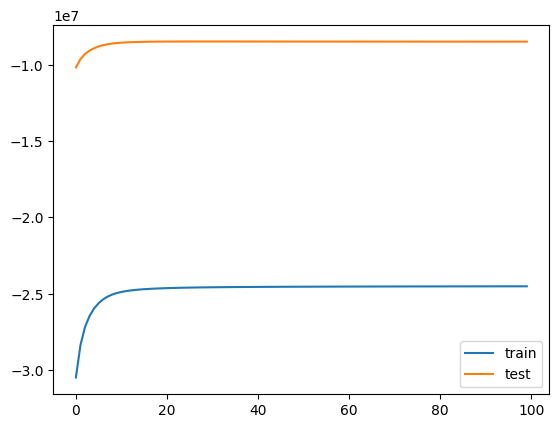

In [41]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

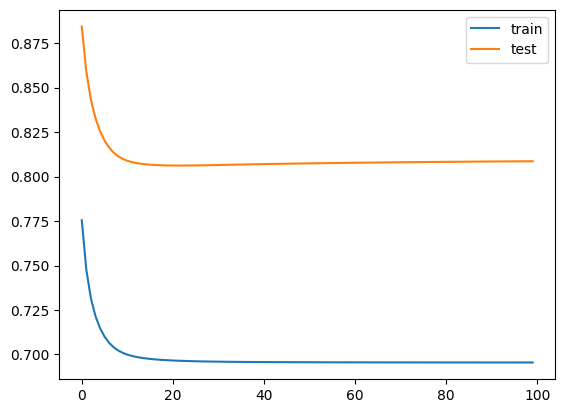

In [42]:
plt.plot(train_rmses, label='train')
plt.plot(test_rmses, label='test')
plt.legend()
plt.show()